# Begin visualisations

In [1]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress

In [2]:
working = Path('..')
working

PosixPath('..')

In [3]:
!pwd

/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/notebooks


In [4]:
!ls $working

LICENSE                    load_hapaxes.py
Project History.pdf        load_jaccard.py
README.md                  load_ngram_intersects.py
__pycache__                load_ngrams.py
arch                       load_relationships.py
authors.txt                make_3d_plot.py
auto_author_prediction.py  make_auto_scatterplot.py
begin.sh                   make_confusion.py
cleaning_splitting_scripts make_dash.py
database_ops.py            make_histogram.py
dh-trace-venv              make_jumbo_dash.py
diagrams.ipynb             make_lines.py
do_svm.py                  notebooks
do_viz.sh                  poetry.lock
explore                    predict_ops.py
hapaxes_1tM.py             projects
init_db.py                 pyproject.toml
jan24                      requirements.txt
load_alignments.py         show_previous_averages.py
load_authors_and_texts.py  util.py
load_hapax_intersects.py   utils


In [5]:
things = working.glob('*')

In [6]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../cleaning_splitting_scripts
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../__pycache__
../load_hapaxes.py
../Project History.pdf
../jan24
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [7]:
project_name = 'eltec-100'
project_path = working / 'projects' / project_name

In [8]:
project_path

PosixPath('../projects/eltec-100')

In [9]:
db_path = project_path / 'db' / f'{project_name}.db'
db_path

PosixPath('../projects/eltec-100/db/eltec-100.db')

In [10]:
db_path.exists()

True

In [11]:
EDGES_QUERY = """
SELECT 
    calculation.pair_id,
    round(calculation.comp_score, 3) as comp_score,
    threshold,
    weight.weight_id,
    weight.hap_weight,
    weight.al_weight,
    text_pair.text_a AS a_text_id,
    text_pair.text_b AS b_text_id,
    text_a.source_filename AS a_text_filename,
    text_b.source_filename AS b_text_filename,
    dir_a.id AS a_work_dir_id,
    dir_b.id AS b_work_dir_id,
    dir_a.dir AS a_work,
    dir_b.dir AS b_work,
    text_a.author_id AS a_author_id,
    text_b.author_id AS b_author_id,
    calculation.same_author,
    author_a.author_name AS a_author,
    author_b.author_name AS b_author
FROM calculations AS calculation
    JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
    JOIN weights AS weight ON weight.weight_id = calculation.weight_id
    JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
    JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
    JOIN dirs AS dir_a ON dir_a.id = text_a.dir
    JOIN dirs AS dir_b ON dir_b.id = text_b.dir
    JOIN authors AS author_a ON author_a.id = text_a.author_id
    JOIN authors AS author_b ON author_b.id = text_b.author_id
    -- WHERE -- calculation.weight_id = 10
    -- AND threshold = 0.75
    -- AND a_author_id <> b_author_id
    ORDER BY pair_id
    -- LIMIT 10
"""
#add LIMIT 10 at bottom to limit results to first 10

In [12]:
EDGES_QUERY

'\nSELECT \n    calculation.pair_id,\n    round(calculation.comp_score, 3) as comp_score,\n    threshold,\n    weight.weight_id,\n    weight.hap_weight,\n    weight.al_weight,\n    text_pair.text_a AS a_text_id,\n    text_pair.text_b AS b_text_id,\n    text_a.source_filename AS a_text_filename,\n    text_b.source_filename AS b_text_filename,\n    dir_a.id AS a_work_dir_id,\n    dir_b.id AS b_work_dir_id,\n    dir_a.dir AS a_work,\n    dir_b.dir AS b_work,\n    text_a.author_id AS a_author_id,\n    text_b.author_id AS b_author_id,\n    calculation.same_author,\n    author_a.author_name AS a_author,\n    author_b.author_name AS b_author\nFROM calculations AS calculation\n    JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id\n    JOIN weights AS weight ON weight.weight_id = calculation.weight_id\n    JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a\n    JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b\n    JOIN dirs AS dir_a ON dir_a.id = text_a.

In [13]:
con = sqlite3.connect(db_path)

In [14]:
#creates a view of the extensive query above and lets me work with it as if it's a table
with suppress(OperationalError):
    con.execute(f"""
    CREATE VIEW edges
    AS
    {EDGES_QUERY}
    """)
#TODO - check suppression of errors

In [26]:
edges_df = pd.read_sql("""
SELECT * 
FROM edges 
WHERE a_work_dir_id <> b_work_dir_id
-- AND weight_id = 10 
-- AND threshold = 0.9
-- LIMIT 500
""", con)

In [27]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 
edges_df = edges_df.sample(1000)

In [28]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [29]:
G

In [30]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

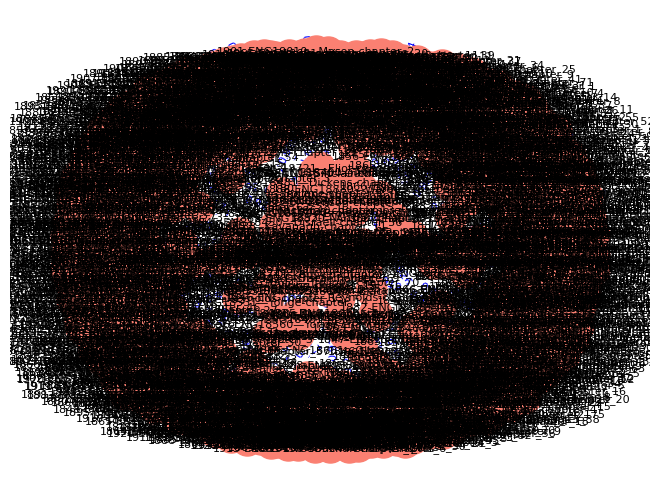

In [31]:
# Draw nodes with labels
TEXT_FONT_SIZE = 8
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True, font_size=TEXT_FONT_SIZE)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [32]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)
C.set_style(
    [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f'{TEXT_FONT_SIZE}px',
                 'label': 'data(id)'
                 
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f'{TEXT_FONT_SIZE}px',
                 'color': 'blue',
                 'label': 'data(comp_score)',
                 'width': '1px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            },
        },        
        {
             'selector': 'edge[comp_score>0.92]',
             'style': {
                 'width': '3px',
             }
        }
    ])

In [33]:
C.set_layout?

Signature: C.set_layout(**kwargs)
Docstring:
Sets the layout of the current object. Change the parameters individually.
For extensive documentation on the different kinds of layout please refer
to https://js.cytoscape.org/#layouts

Parameters
----------
name : str
    name of the layout, ex.: cola, grid.
nodeSpacing : int
edgeLengthVal : int
padding : int
    adds padding to the whole graph in comparison to the Jupyter's cell
**kwargs :
    All kwargs will be added to the dictionary of the layout.
File:      ~/Library/Caches/pypoetry/virtualenvs/thesis-code-kwfQCT4c-py3.11/lib/python3.11/site-packages/ipycytoscape/cytoscape.py
Type:      method

In [34]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

In [ ]:
3